In [19]:
import numpy as np
import pandas as pd
import math
import os
import scipy.misc
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import to_categorical
%matplotlib inline 
# from keras import keras.layer

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
import itertools

In [21]:
dataset=pd.read_csv("fer2013.csv")

In [22]:
dataset.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


0


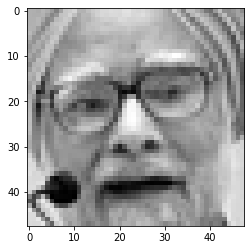

2


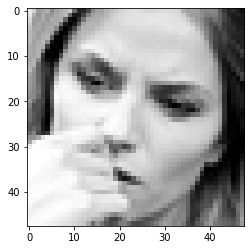

4


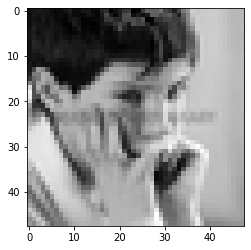

6


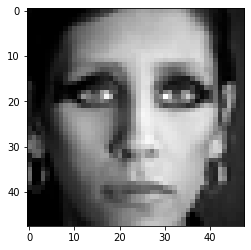

2


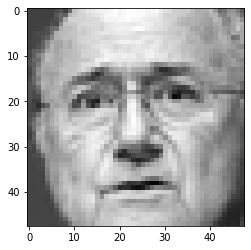

4


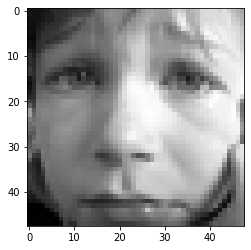

In [23]:
for i in range (1,7):
    print(dataset.emotion[i])
    array = np.mat(dataset.pixels[i]).reshape(48,48) 
    plt.imshow(array,cmap='gray')
    plt.show()


In [24]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [25]:
#X,y=dataset['pixels'],dataset['emotion']
dataset.count()

emotion    35887
pixels     35887
Usage      35887
dtype: int64

<b>we dont have any missing value</b>

In [26]:
dataset.groupby('Usage').size()

Usage
PrivateTest     3589
PublicTest      3589
Training       28709
dtype: int64

In [27]:
train_ds=dataset[dataset['Usage']=='Training']
test_ds=dataset[dataset['Usage']=='PrivateTest']
val_ds=dataset[dataset['Usage']=='PublicTest']


In [28]:
test_ds.count()

emotion    3589
pixels     3589
Usage      3589
dtype: int64

In [29]:
val_ds.count()

emotion    3589
pixels     3589
Usage      3589
dtype: int64

In [30]:
train_ds.count()

emotion    28709
pixels     28709
Usage      28709
dtype: int64

In [31]:
type(dataset.pixels[0])

str

In [32]:
X_train= np.array(list(map(str.split, train_ds.pixels)), np.float32)
X_test=np.array(list(map(str.split,test_ds.pixels)),np.float32)
X_val=np.array(list(map(str.split,val_ds.pixels)),np.float32)

In [33]:
image_size=int(math.sqrt(X_train[0].shape[0]))# =48 calculate  original image width_hight

In [34]:
# image shape as (H, W, D)
X_train=X_train.reshape((X_train.shape[0],image_size,image_size,1)) # generate (48,48,1) images
X_test=X_test.reshape((X_test.shape[0],image_size,image_size,1))
X_val=X_val.reshape((X_val.shape[0],image_size,image_size,1))

In [35]:
type(dataset.emotion[0])

numpy.int64

In [36]:
num_classes = 7

y_train=train_ds.emotion
y_train = to_categorical(y_train, num_classes) 
y_test=test_ds.emotion
y_test=to_categorical(y_test,num_classes)
y_val=val_ds.emotion
y_val=to_categorical(y_val,num_classes)

<h2>Vgg19 model</h2>

<a><img src='./vgg16.png' title='vgg16' ></a>

In [39]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_3 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_4 = BatchNormalization()(conv5_4)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [40]:
model = FER_Model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
drop1_1 (Dropout)            (None, 24, 24, 64)        0     

In [41]:
opt=tf.keras.optimizers.Adam()
loss=tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])


<p style="color:red;"> model with out data generator</p>

In [44]:
checkpoint_path = "./training_checkpoints/"
! mkdir -p {checkpoint_path}
checkpoint_dir2 = os.path.join(checkpoint_path,"ckpt_{epoch}")
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)



In [45]:
history2=model.fit(train_flow,
                   batch_size=batch_size,
                   epochs=100,
                   callbacks=[cp_callback2],
                   validation_data=val_flow)

Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 2.3600 - accuracy: 0.2409
Epoch 00001: saving model to ./training_checkpoints_datagen/ckpt_1
449/449 [==============================] - 15s 33ms/step - loss: 2.3594 - accuracy: 0.2407 - val_loss: 7.5104 - val_accuracy: 0.2385
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 2.0106 - accuracy: 0.2581
Epoch 00002: saving model to ./training_checkpoints_datagen/ckpt_2
449/449 [==============================] - 14s 31ms/step - loss: 2.0106 - accuracy: 0.2581 - val_loss: 4.2537 - val_accuracy: 0.2616
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.8451 - accuracy: 0.2830
Epoch 00003: saving model to ./training_checkpoints_datagen/ckpt_3
449/449 [==============================] - 14s 32ms/step - loss: 1.8451 - accuracy: 0.2830 - val_loss: 1.7378 - val_accuracy: 0.3001
Epoch 4/100
449/449 [==============================] - ETA: 0s - loss: 1.6610 - accuracy: 0.3467
Epoch 00004:

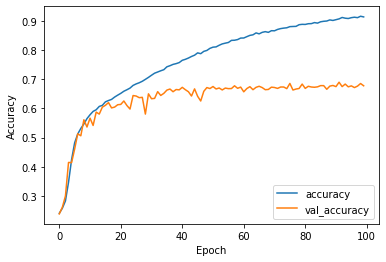

In [46]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
plt.savefig("datagen.png")

In [48]:
!mkdir -p vgg_model
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets
